# **SemEval: 2025**


# Data Exploration: Hazard and Product Classification

## 1. Introduction
In this notebook, we explore the dataset that will be used for hazard and product classification. The primary steps performed in this analysis include:
- **Loading the dataset**
- **Data cleaning**
- **Exploratory data analysis (EDA)**:
  - Distribution of hazard and product categories
  - Trend of the distribution of hazard and product class labels
  - Length of titles and text

This exploration helps us understand the structure of the data, identify potential issues, and inform decisions on how to approach modeling.


---

**Import the necessary libraries.**

---

In [10]:
!pip install datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # For loading and processing data
import re  # For regex-based text cleaning
from nltk.corpus import stopwords  # For removing stopwords
from nltk.stem import WordNetLemmatizer  # For lemmatization
from sklearn.model_selection import train_test_split # For train-test split 
from sklearn.feature_extraction.text import TfidfVectorizer #transforms the text data into numerical features (using TF-IDF)

# Make sure to download the necessary NLTK resources 
import nltk
nltk.download('stopwords')  # Download stopwords
nltk.download('wordnet')  # Download WordNet for lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
!pip install imblearn
from imblearn.over_sampling import SMOTE
import numpy as np
import os




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

**Load the datasets.**

---


We have three CSV files:

* Train labeled dataset: This file contains the labeled data, where both the text (either title or full text) and the associated labels (e.g., hazard-category, product-category) are available.
* Validation unlabeled dataset: This file contains unlabeled data, which will be used to evaluate the model’s performance during training.
* Test unlabeled dataset: This file contains the data that will be used for making final predictions. Like the validation set, it lacks labels, and the predictions made on this dataset will be submitted for evaluation.

To begin exploring our data, we will load these CSV files.

In [11]:
# url of train labeled dataset
url_labeled_data = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/labeled_trial-training_data(5028samples).csv'
# load training data
train_data = pd.read_csv(url_labeled_data)

train_data.head()
# url of unlabeled test set
url_testset = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/unlabeled_test_data(997).csv'
# load the test data
test_data = pd.read_csv(url_testset)

test_data.head()
# url of unlabeled validation set
url_validation_set = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/unlabeled_validation_data(565).csv'
# load the validation data
validation_data = pd.read_csv(url_validation_set)

train_data.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


---

**Data Cleaning**

---

To prepare the text data for further analysis or model training, we first clean the text. This includes several preprocessing steps like converting the text to lowercase, removing special characters and numbers, and lemmatizing the words. Additionally, we remove common stopwords (like "the", "is", "and", etc.) that do not add significant meaning for the task at hand.

* First, we initialize the **stopwords** and **lemmatizer**. The stopwords are a list of commonly used words in English that are not useful in the text classification task. The lemmatizer will reduce words to their base form, making it easier for the model to recognize similar words.
* We then define a function, clean_text, that performs the following operations:
    * Lowercasing: Converts all text to lowercase, ensuring that same words are treated the same.
    * Removing Special Characters: Using a regular expression, it removes any non-alphanumeric characters (like punctuation marks).
    * Removing Numbers: Another regular expression removes any numerical values that might not be relevant for the text classification task.
    * Stopwords Removal and Lemmatization: For each word in the text, we check if it is a stopword and if not, we apply lemmatization to reduce it to its base form.
* Finally, we apply this cleaning function to the 'title' column of the dataset and save them in a csv file.

In [12]:
# Drop unnecessary columns
# This removes any columns that are not required for analysis or modeling, such as 'Unnamed: 0'.
columns_to_drop = ['Unnamed: 0']
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# Normalize text fields (lowercasing and stripping extra spaces)
# Ensures consistent formatting for text by converting to lowercase and removing leading/trailing spaces.
train_data_cleaned["title"] = train_data_cleaned["title"].str.lower().str.strip()
train_data_cleaned["text"] = train_data_cleaned["text"].str.lower().str.strip()

# Compute text lengths# Drop unnecessary columns
# This removes any columns that are not required for analysis or modeling, such as 'Unnamed: 0'.
columns_to_drop = ['Unnamed: 0']
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# Initialize Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function that cleans the text
def clean_text(text):
    text = text.lower() # Convert words to lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', ' ', text)      # Remove numbers
    words = text.split()
    # if word not a stopword, processed by lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Add a cleaned_text column with the cleaned title
train_data['cleaned_title'] = train_data['title'].apply(clean_text)
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

# Calculates the number of words in the 'title' and 'text' columns and stores them in new columns.
train_data_cleaned["title_length"] = train_data_cleaned["title"].str.split().apply(len)
train_data_cleaned["text_length"] = train_data_cleaned["text"].str.split().apply(len)

# Save the updated DataFrame to a new CSV file
output_file_path = "C:\\Users\\magda\\Desktop\\pratical ds\\Semeval2025-2\\data\\cleaned_train_data.csv"
train_data_cleaned.to_csv(output_file_path, index=False)

print(f"Cleaned data saved to {output_file_path}")


Cleaned data saved to C:\Users\magda\Desktop\pratical ds\Semeval2025-2\data\cleaned_train_data.csv


---

Exploratory Data Analysis

---

1. **Distributions of Product and Hazard Categories**

a.  **Hazard Category:**

The first plot illustrates the distribution of the 10 hazard categories (x-axis) and their corresponding counts (y-axis). Categories such as "allergens" and "biological" are highly prevalent, dominating the dataset. In contrast, other categories are significantly underrepresented, highlighting an imbalanced distribution of hazard types.

b.  **Product Category:**

The second plot shows the distribution of the 22 product categories (x-axis) along with their counts (y-axis). Certain categories, such as "meat, egg, and dairy products", appear frequently in the dataset. Similar to the hazard categories, this distribution is also imbalanced, with some product categories occurring much less frequently than others.

C:\Users\magda\AppData\Local\Temp\ipykernel_18232\4167529595.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hazard_category_counts.index, y=hazard_category_counts.values, palette="viridis")
C:\Users\magda\AppData\Local\Temp\ipykernel_18232\4167529595.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_category_counts.index, y=product_category_counts.values, palette="plasma")


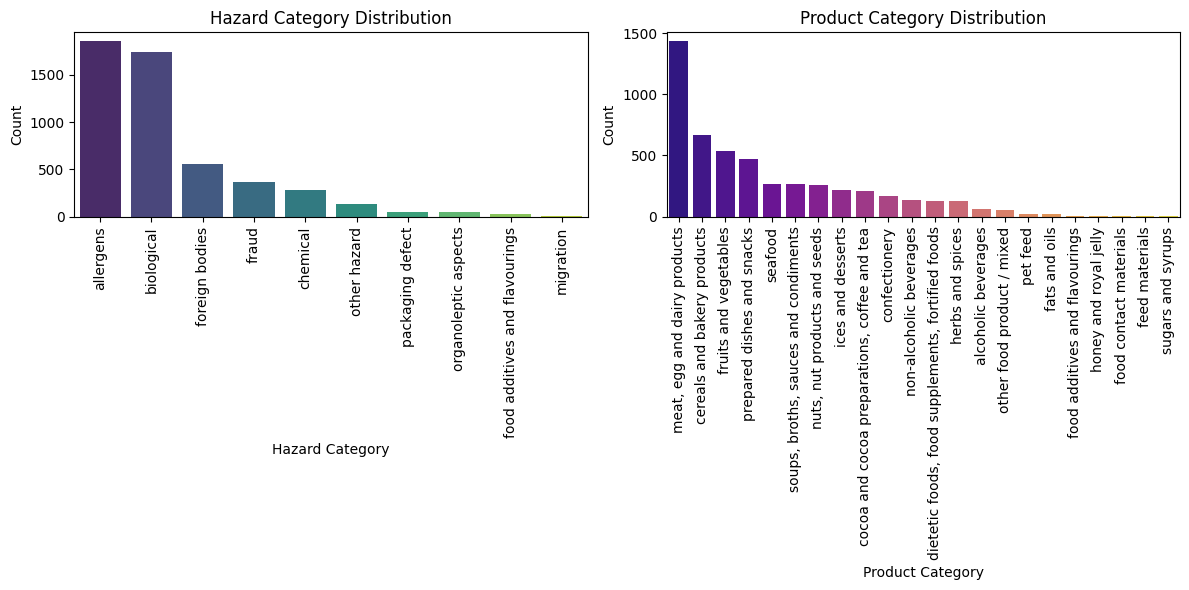

In [13]:
url_train_data = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/cleaned_train_data.csv'
train_data = pd.read_csv(url_labeled_data)

# Class distributions for hazard-category and product-category
# Count the occurrences of each unique value in 'hazard-category' and 'product-category' columns.
hazard_category_counts = train_data_cleaned["hazard-category"].value_counts()
product_category_counts = train_data_cleaned["product-category"].value_counts()

# Plotting class distributions
# Create a figure with two subplots to visualize the distributions of hazard and product categories.
plt.figure(figsize=(12, 6))

# Subplot 1: Hazard Category Distribution
plt.subplot(1, 2, 1)  # First subplot in a 1-row, 2-column layout
sns.barplot(x=hazard_category_counts.index, y=hazard_category_counts.values, palette="viridis")
plt.title("Hazard Category Distribution")  # Title for the first plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Hazard Category")  # Label for x-axis
plt.ylabel("Count")  # Label for y-axis

# Subplot 2: Product Category Distribution
plt.subplot(1, 2, 2)  # Second subplot in a 1-row, 2-column layout
sns.barplot(x=product_category_counts.index, y=product_category_counts.values, palette="plasma")
plt.title("Product Category Distribution")  # Title for the second plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Product Category")  # Label for x-axis
plt.ylabel("Count")  # Label for y-axis

# Adjust layout to prevent overlapping and improve visualization
plt.tight_layout()

# Display the plots
plt.show()


2. **Top 20 most frequent Hazards and Products**

a. **Hazard Subplot**

In the hazard subplot, we observe that a few hazards, such as Listeria monocytogenes, Salmonella, and Milk and products thereof, dominate the dataset with significantly higher counts compared to the rest. The distribution follows a long-tail pattern, where the frequency of hazards decreases rapidly after the top few, indicating that most hazards are relatively rare.

For styling, the dot size and gridlines enhance clarity, making the visualization easy to read. Counts are annotated next to the dots for added precision. The coolwarm color palette is used to highlight the urgency, with warm colors (reds) drawing attention to the high-frequency hazards like Listeria and Salmonella, emphasizing their importance.

b. **Product Subplot**

In the product subplot, we observe that certain products, like Ice Cream and Chicken-based products, are associated with hazards much more frequently than others. The distribution shows a noticeable skew, with the majority of products having low counts, while a few stand out with high frequencies.

For styling, a color gradient is used to highlight variations in frequency. Counts are annotated near the dots for added clarity. The viridis palette is chosen for its colorblind-friendly properties and subtle highlight of frequency, with higher counts represented in bright green. This palette provides a neutral tone that is well-suited for visualizing product categories.

C:\Users\magda\AppData\Local\Temp\ipykernel_18232\766919429.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\magda\AppData\Local\Temp\ipykernel_18232\766919429.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


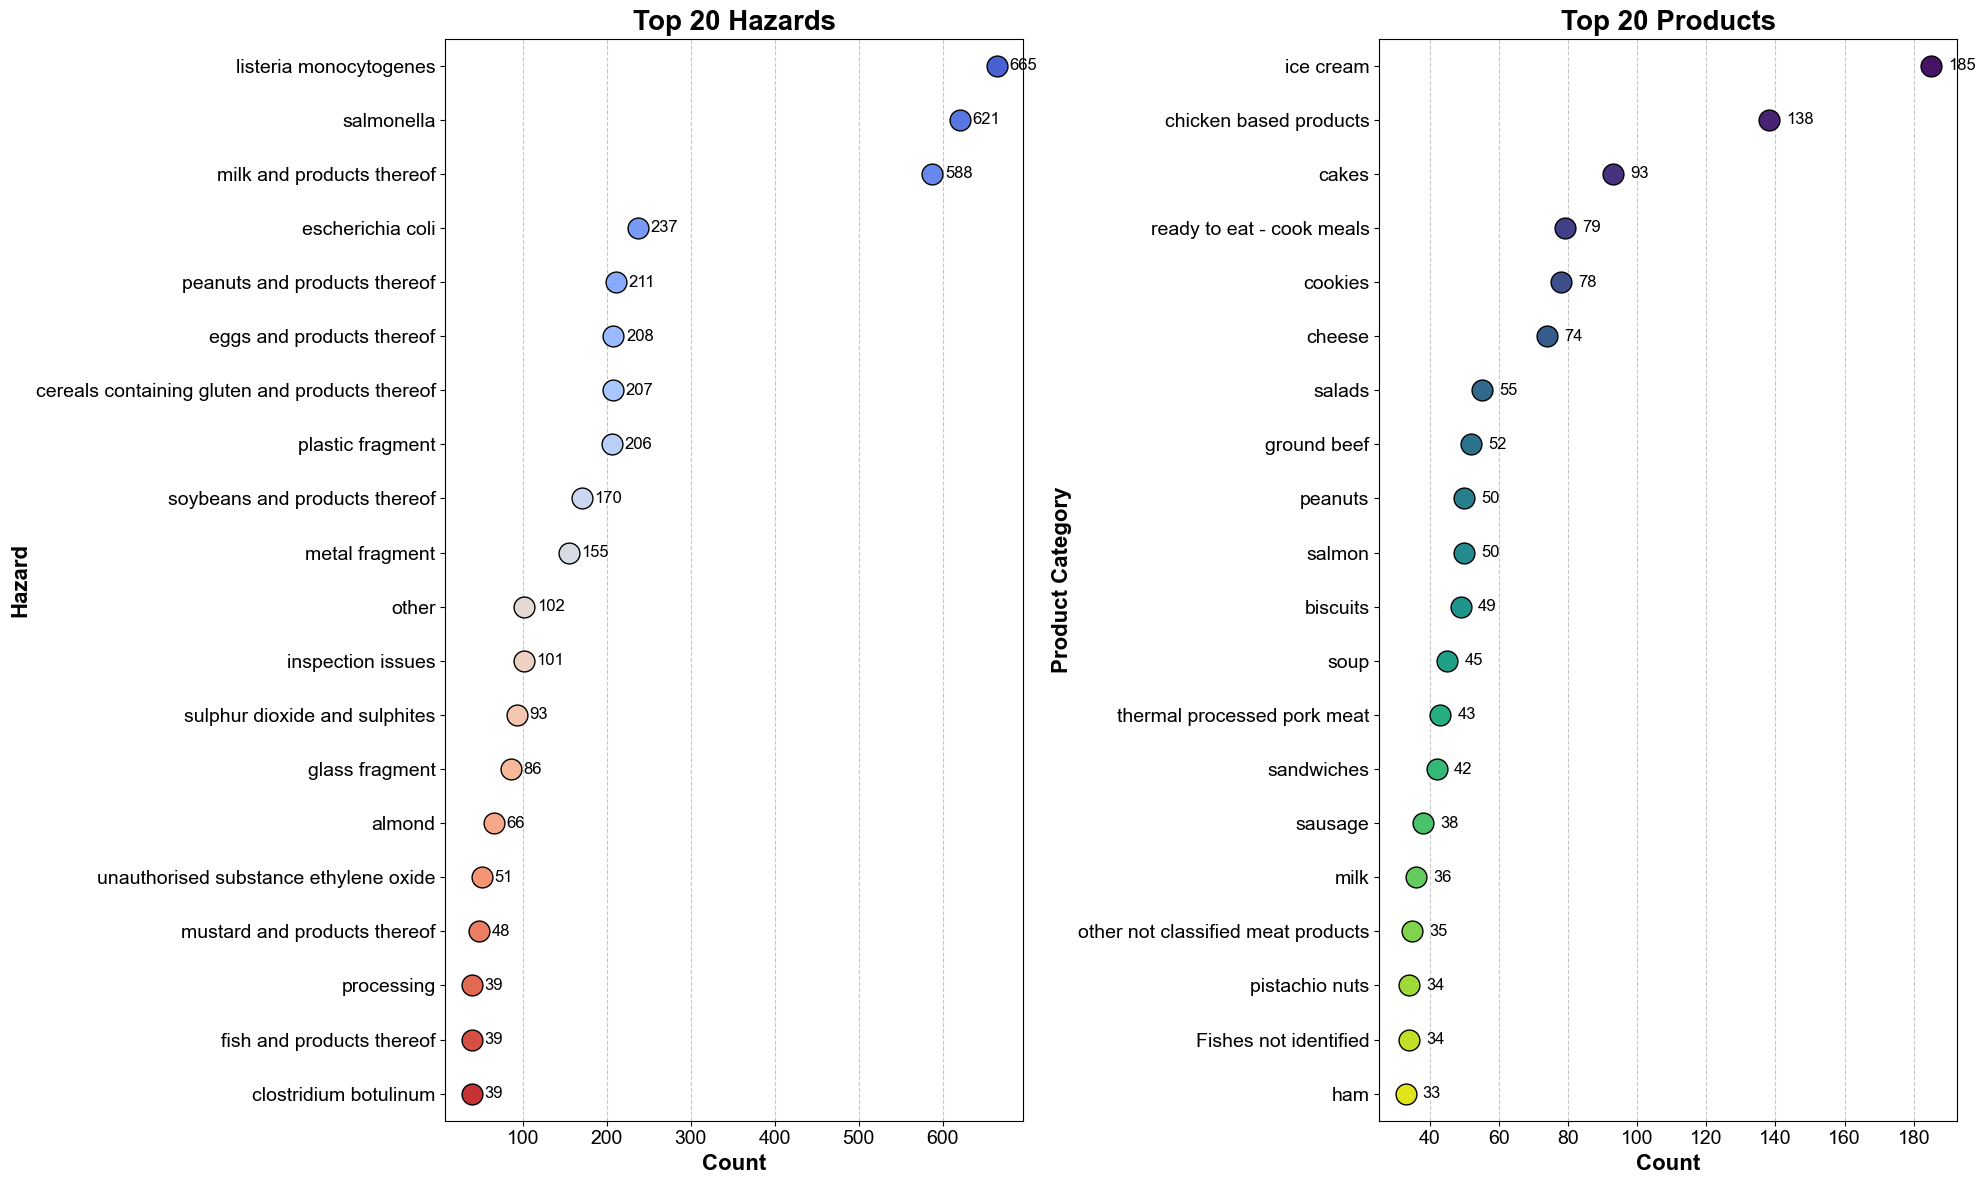

In [14]:
# Parameters for visualization
top_n = 20  # Display only the top N categories for better readability

# Count the occurrences of each unique value in the hazard and product columns
hazard_counts = train_data_cleaned["hazard"].value_counts()
product_counts = train_data_cleaned["product"].value_counts()

# Select only the top N categories for visualization
top_hazard_counts = hazard_counts.head(top_n)
top_product_counts = product_counts.head(top_n)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # Set figure size for better readability

# Set the style of the plot to enhance readability
sns.set_theme(style="whitegrid")  # Add a grid background

# --- Subplot 1: Hazards ---
sns.stripplot(
    y=top_hazard_counts.index,            # Categories on the y-axis
    x=top_hazard_counts.values,           # Counts on the x-axis
    ax=axes[0],                           # Specify subplot axis
    palette="coolwarm",                   # Color palette for the plot
    size=15,                              # Size of the dots
    linewidth=1,                          # Thickness of dot edges
    edgecolor="black",                    # Black edges around the dots
    orient="h"                            # Horizontal orientation
)

# Add a title and labels to the Hazard subplot
axes[0].set_title(f"Top {top_n} Hazards", fontsize=20, weight="bold")  # Title with font styling
axes[0].set_xlabel("Count", fontsize=16, weight="bold")                # X-axis label
axes[0].set_ylabel("Hazard", fontsize=16, weight="bold")               # Y-axis label
axes[0].tick_params(axis='both', which='major', labelsize=14)          # Increase tick label size
axes[0].grid(True, which="major", axis="x", linestyle="--", alpha=0.7) # Add gridlines on the x-axis

# Annotate each dot with its count value, slightly shifted for clarity
for i, count in enumerate(top_hazard_counts.values):
    axes[0].text(count + 15, i, str(count), va="center", ha="left", fontsize=12, color="black")  # Text annotation

# --- Subplot 2: Products ---
sns.stripplot(
    y=top_product_counts.index,           # Categories on the y-axis
    x=top_product_counts.values,          # Counts on the x-axis
    ax=axes[1],                           # Specify subplot axis
    palette="viridis",                    # Color palette for the plot
    size=15,                              # Size of the dots
    linewidth=1,                          # Thickness of dot edges
    edgecolor="black",                    # Black edges around the dots
    orient="h"                            # Horizontal orientation
)

# Add a title and labels to the Product subplot
axes[1].set_title(f"Top {top_n} Products", fontsize=20, weight="bold")  # Title with font styling
axes[1].set_xlabel("Count", fontsize=16, weight="bold")                 # X-axis label
axes[1].set_ylabel("Product Category", fontsize=16, weight="bold")      # Y-axis label
axes[1].tick_params(axis='both', which='major', labelsize=14)           # Increase tick label size
axes[1].grid(True, which="major", axis="x", linestyle="--", alpha=0.7)  # Add gridlines on the x-axis

# Annotate each dot with its count value, slightly shifted for clarity
for i, count in enumerate(top_product_counts.values):
    axes[1].text(count + 5, i, str(count), va="center", ha="left", fontsize=12, color="black")  # Text annotation

# Adjust layout to prevent overlapping and improve visualization
plt.tight_layout()

# Display the plots
plt.show()


3. **Title & Text Length Analysis**

To better understand the length of both titles and full texts, we calculated the number of words in each title and text. We then visualized the distributions of these text lengths using histograms and computed the mean values.



a. **Title Lengths Plot**

The histogram for title lengths shows the distribution of the number of words in the title field (x-axis: title length, y-axis: number of titles with each length). The distribution reveals that most titles have between 5 and 20 words, indicating a relatively narrow range of lengths. The plot’s peak (mode) suggests that the majority of titles are around 10–15 words long. The distribution gradually tapers off, with fewer titles exceeding 20 words.

Mean Title Length: 13


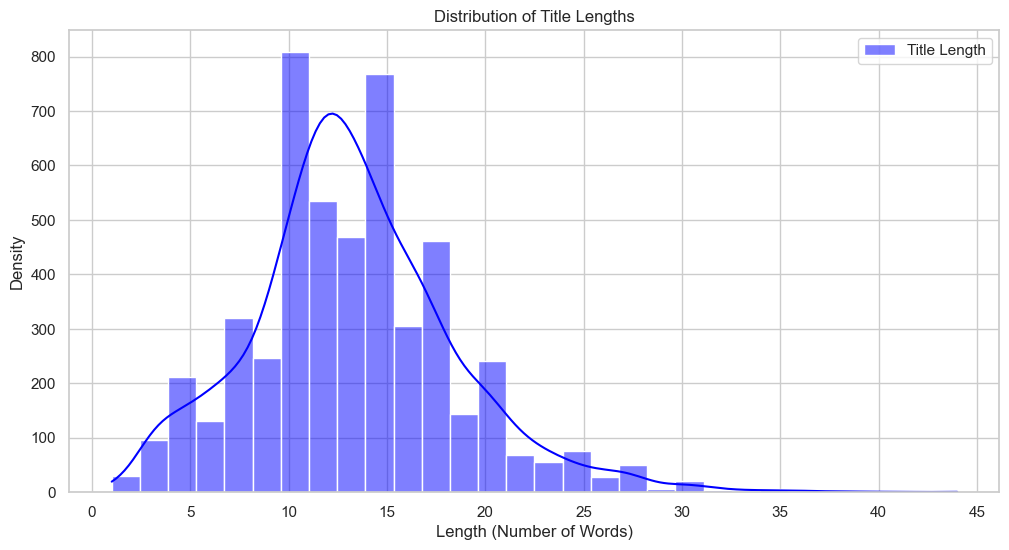

In [15]:
# Text length analysis
# Extract the title lengths column for analysis.
title_lengths = train_data_cleaned["title_length"]

# Calculate mean for title length
# Compute the average number of words in the 'title' column.
mean_title_length = train_data_cleaned["title_length"].mean()
print(f"Mean Title Length: {int(mean_title_length)}")  # Print the mean title length as an integer.

# Plot the distribution of title lengths
plt.figure(figsize=(12, 6))  # Set the figure size for the plot.

# Use seaborn to create a histogram with a density estimate.
sns.histplot(title_lengths, bins=30, kde=True, color="blue", label="Title Length")

# Customize x-axis ticks for better readability and more granular intervals.
plt.xticks(np.arange(0, train_data_cleaned["title_length"].max() + 5, 5))  

# Add plot titles and axis labels for better understanding.
plt.title("Distribution of Title Lengths")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Density")

# Add a legend to identify the plot line.
plt.legend()

# Display the plot.
plt.show()


b. **Text Lengths**

The histogram for text lengths shows the distribution of the number of words in the text field (x-axis: text length, y-axis: number of texts with each length). Compared to the title lengths, the distribution of text lengths is much broader, with word counts ranging from around 50 to over 600 words. A noticeable peak (mode) occurs near 300–400 words, but the distribution exhibits significant variance, as shown by its wide spread. The tail extends toward higher word counts, with some texts exceeding 600 words.

Mean Text Length: 353


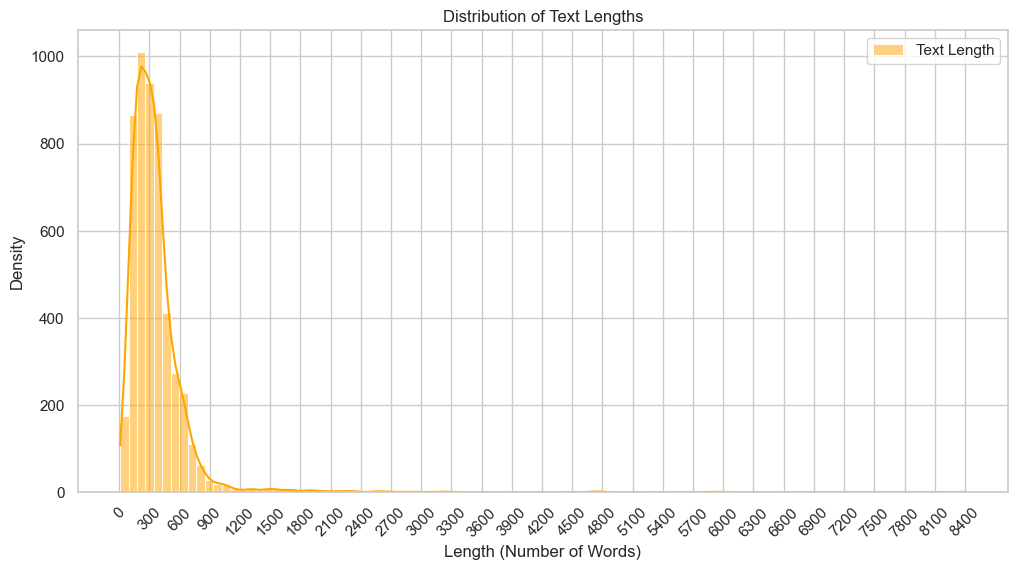

In [16]:

# Extract the text lengths column for analysis
text_lengths = train_data_cleaned["text_length"]

# Calculate mean for text length
# Compute the average number of words in the 'text' column.
mean_text_length = train_data_cleaned["text_length"].mean()
print(f"Mean Text Length: {int(mean_text_length)}")  # Print the mean text length as an integer.

# Illustrate the distribution of text lengths
plt.figure(figsize=(12, 6))  # Set the figure size for the plot.

# Use seaborn to create a histogram with a density estimate (KDE).
sns.histplot(text_lengths, bins=100, kde=True, color="orange", label="Text Length")

# Customize x-axis ticks to show intervals of 300 words, and rotate them for better readability.
plt.xticks(np.arange(0, train_data_cleaned["text_length"].max(), 300), rotation=45)

# Add plot titles and axis labels for clarity.
plt.title("Distribution of Text Lengths")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Density")

# Add a legend to identify the plot line.
plt.legend()

# Display the plot.
plt.show()


### **Summary of Findings from Preprocessing and Exploratoty Data Analysis**

#### **Class Distributions**
1. **Hazard Categories**:
   - Some categories dominate the dataset.
   - Others are underrepresented, reflecting an imbalanced distribution.

2. **Product Categories**:
   - Categories like "meat, egg and dairy products" appear frequently.
   - Similar imbalances as seen with hazard categories.

3. **Hazards**:
   - A few hazards, like Listeria monocytogenes and Salmonella, dominate the dataset with high frequencies.
   - Most other hazards have much lower counts, creating a long tail with many rare hazards.

4. **Products**:
   - A small number of products, such as Ice Cream and Chicken-based products, have significantly higher counts.
   - Other products are much less frequent, showing a skewed distribution with many products having low counts.



#### **Text and Titles Lengths**
1. **Titles**:
   - Typically concise, averaging **13 words**.
   - Ideal for short-text classification tasks.

2. **Texts**:
   - Richer in detail, averaging **350 words**.
   - Suitable for more complex analysis and classification.